>>CodeBERT + Logistic Regression

In [ ]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)

# ===============================
# Load dataset
# ===============================
df = pd.read_csv("Code_Comment_Seed_Data.csv", on_bad_lines='skip')
df["text"] = df["Comments"].astype(str) + " " + df["Surrounding Code Context"].astype(str)

# Remove rows where 'Class' is None before splitting for stratification
df = df.dropna(subset=['Class'])

print("Original class distribution:\n", df["Class"].value_counts())

# Train/Val/Test Split
train_df, test_df = train_test_split(df, test_size=0.20, stratify=df["Class"], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.25, stratify=train_df["Class"], random_state=42)

print(f"Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")

# ===============================
# Convert labels to numeric
# ===============================
label_map = {"Not Useful": 0, "Useful": 1}
train_df["label"] = train_df["Class"].map(label_map)
val_df["label"] = val_df["Class"].map(label_map)
test_df["label"] = test_df["Class"].map(label_map)

# ===============================
# Hugging Face Datasets
# ===============================
train_ds = Dataset.from_pandas(train_df[["text","label"]])
val_ds = Dataset.from_pandas(val_df[["text","label"]])
test_ds = Dataset.from_pandas(test_df[["text","label"]])

# ===============================
# Tokenizer & Model (CodeBERT)
# ===============================
MODEL_NAME = "microsoft/codebert-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

def tokenize_function(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256)

train_tokenized = train_ds.map(tokenize_function, batched=True)
val_tokenized = val_ds.map(tokenize_function, batched=True)
test_tokenized = test_ds.map(tokenize_function, batched=True)

# ===============================
# Metrics function
# ===============================
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": prec, "recall": rec}

# ===============================
# Training Arguments
# ===============================
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="steps",
    eval_steps=500,   # e.g. evaluate every 500 steps

    save_strategy="steps",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,     # ✅ 3–5 epochs
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir="./logs",
    logging_steps=50,
)

# ===============================
# Trainer
# ===============================
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# ===============================
# Train & Evaluate
# ===============================
trainer.train()
results = trainer.evaluate(test_tokenized)
import json

print("Final Test Results:")
print(json.dumps(results, indent=4))


Original class distribution:
 Class
Useful        7063
Not Useful    4389
Name: count, dtype: int64
Train=6870, Val=2291, Test=2291


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/6870 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Map:   0%|          | 0/2291 [00:00<?, ? examples/s]

Map:   0%|          | 0/2291 [00:00<?, ? examples/s]

/tmp/ipython-input-3648685435.py:93: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: samsamuel234567 (samsamuel234567-ssn-institutions) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.183900,0.191623,0.927543,0.943034,0.915390,0.972399
1000,0.118900,0.283626,0.926233,0.941664,0.919137,0.965322
1500,0.074100,0.283996,0.931907,0.945378,0.935551,0.955414
2000,0.108200,0.291935,0.927979,0.943005,0.921053,0.966030


Final Test Results: {'eval_loss': 0.16747526824474335, 'eval_accuracy': 0.934089917066783, 'eval_f1': 0.9480206540447504, 'eval_precision': 0.9229222520107239, 'eval_recall': 0.9745222929936306, 'eval_runtime': 32.1898, 'eval_samples_per_second': 71.172, 'eval_steps_per_second': 4.473, 'epoch': 5.0}


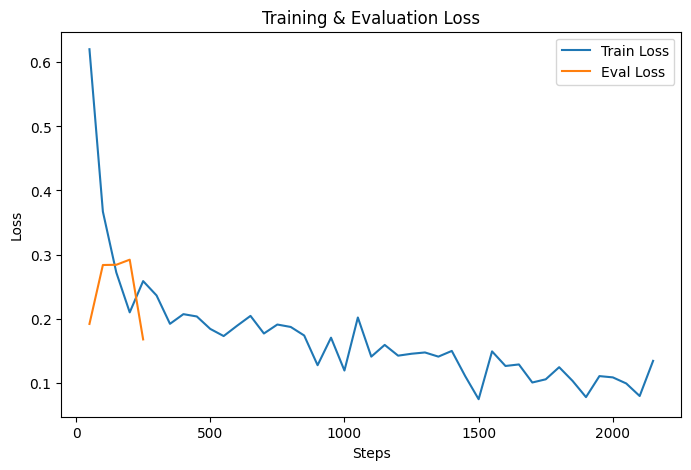

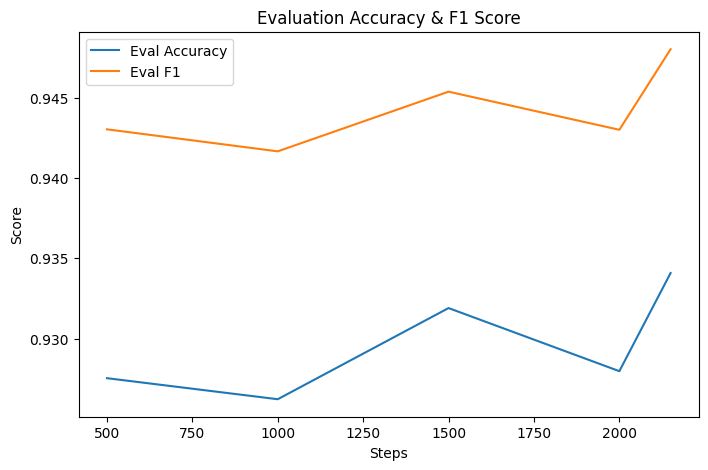

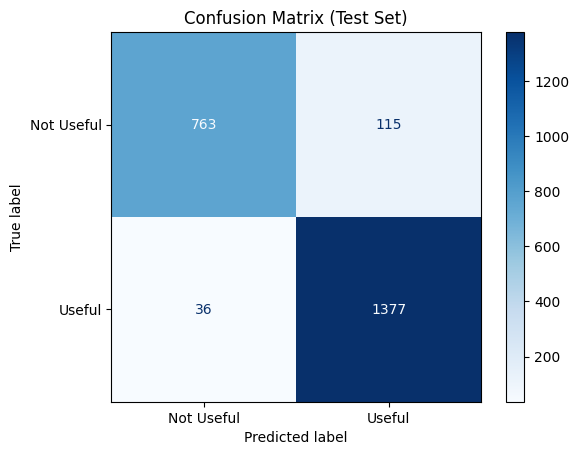

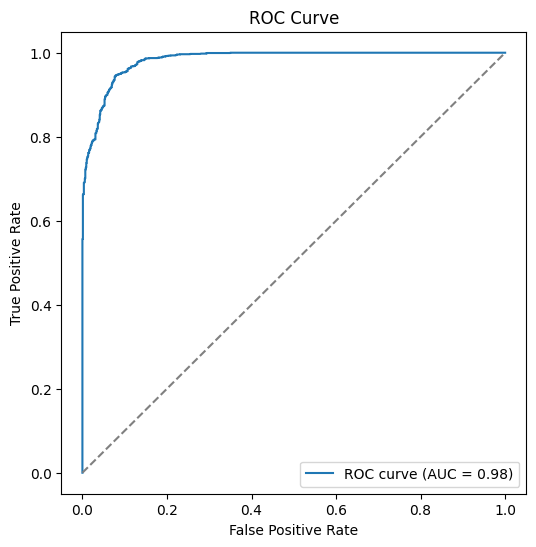

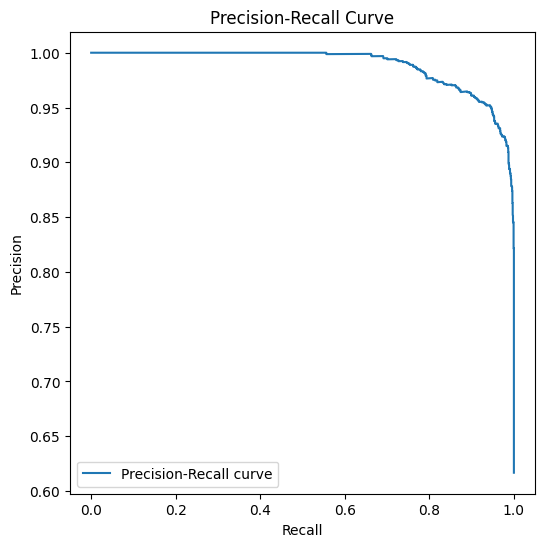

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve

# ===============================
# 1. Plot Training Loss Curve
# ===============================
log_history = trainer.state.log_history
train_loss = [x["loss"] for x in log_history if "loss" in x]
eval_loss = [x["eval_loss"] for x in log_history if "eval_loss" in x]
steps = [x["step"] for x in log_history if "loss" in x]

plt.figure(figsize=(8,5))
plt.plot(steps, train_loss, label="Train Loss")
plt.plot(steps[:len(eval_loss)], eval_loss, label="Eval Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training & Evaluation Loss")
plt.legend()
plt.show()

# ===============================
# 2. Accuracy & F1 over Steps
# ===============================
eval_acc = [x["eval_accuracy"] for x in log_history if "eval_accuracy" in x]
eval_f1 = [x["eval_f1"] for x in log_history if "eval_f1" in x]
eval_steps = [x["step"] for x in log_history if "eval_accuracy" in x]

plt.figure(figsize=(8,5))
plt.plot(eval_steps, eval_acc, label="Eval Accuracy")
plt.plot(eval_steps, eval_f1, label="Eval F1")
plt.xlabel("Steps")
plt.ylabel("Score")
plt.title("Evaluation Accuracy & F1 Score")
plt.legend()
plt.show()

# ===============================
# 3. Confusion Matrix
# ===============================
preds = trainer.predict(test_tokenized)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Useful", "Useful"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Test Set)")
plt.show()

# ===============================
# 4. ROC Curve
# ===============================
y_scores = preds.predictions[:,1]  # probability of class "Useful"
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1],"--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# ===============================
# 5. Precision–Recall Curve
# ===============================
prec, rec, _ = precision_recall_curve(y_true, y_scores)

plt.figure(figsize=(6,6))
plt.plot(rec, prec, label="Precision-Recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


>>with epoch evaluation

Original class distribution:
 Class
Useful        7063
Not Useful    4389
Name: count, dtype: int64
Train=6870, Val=2291, Test=2291


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/6870 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Map:   0%|          | 0/2291 [00:00<?, ? examples/s]

Map:   0%|          | 0/2291 [00:00<?, ? examples/s]

/tmp/ipython-input-4246008200.py:96: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: samsamuel234567 (samsamuel234567-ssn-institutions) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.194300,0.222442,0.929725,0.943961,0.928767,0.959660
2,0.164300,0.192436,0.928852,0.942787,0.935237,0.950460
3,0.143000,0.226166,0.930162,0.944290,0.929404,0.959660
4,0.105200,0.287569,0.927543,0.942441,0.923861,0.961783
5,0.150400,0.325653,0.927106,0.942354,0.919811,0.966030


Final Test Results: {'eval_loss': 0.1668822169303894, 'eval_accuracy': 0.9358358795285902, 'eval_f1': 0.9481115425344158, 'eval_precision': 0.9457746478873239, 'eval_recall': 0.9504600141542817, 'eval_runtime': 29.771, 'eval_samples_per_second': 76.954, 'eval_steps_per_second': 4.837, 'epoch': 5.0}


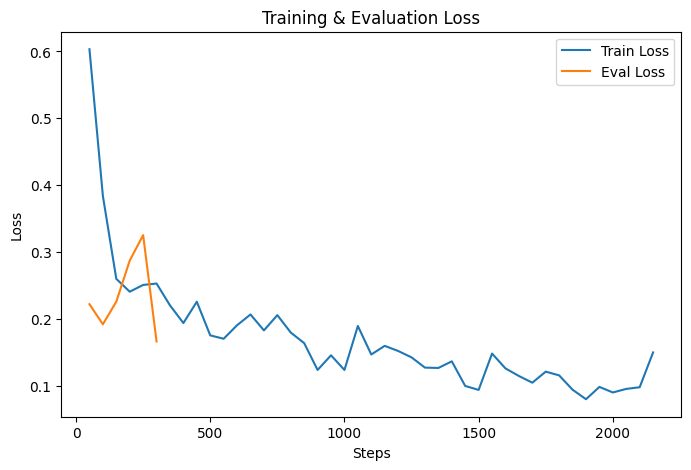

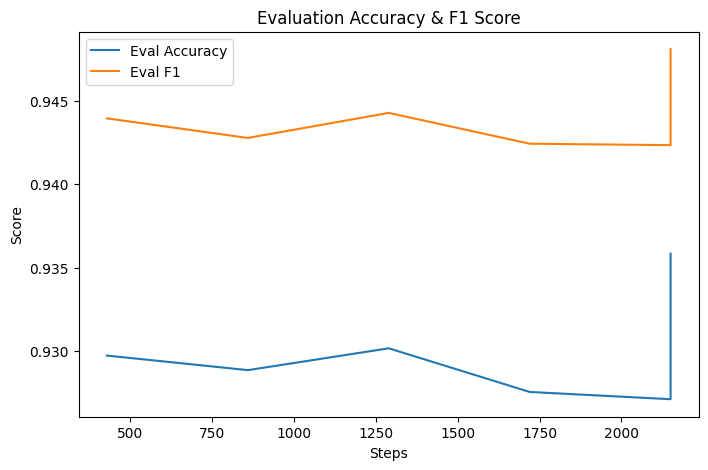

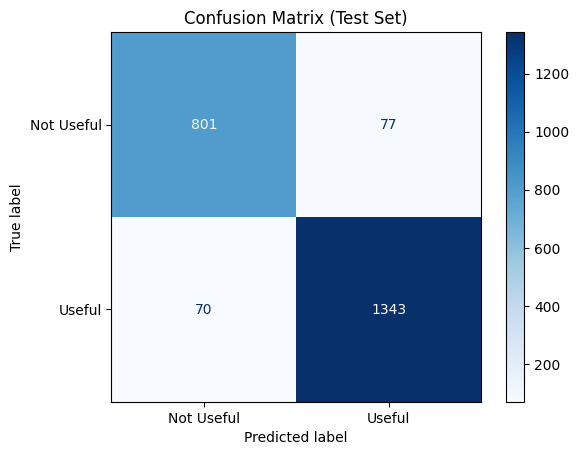

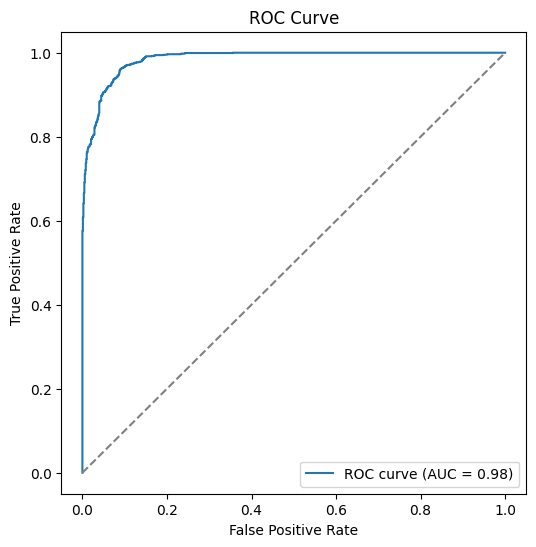

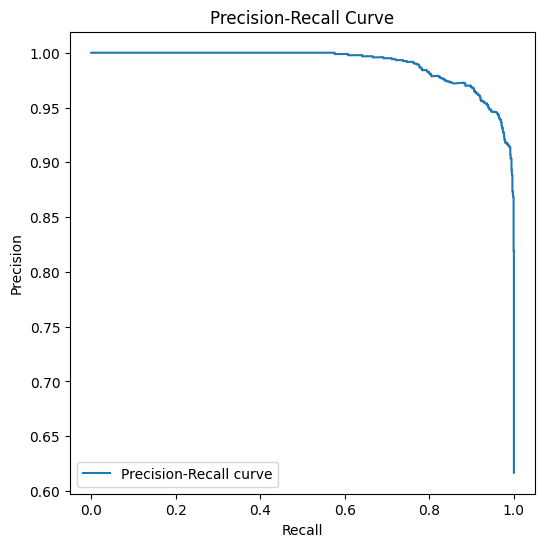

In [2]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split



from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)

# ===============================
# Load dataset
# ===============================
df = pd.read_csv("Code_Comment_Seed_Data.csv", on_bad_lines='skip')
df["text"] = df["Comments"].astype(str) + " " + df["Surrounding Code Context"].astype(str)

# Remove rows where 'Class' is None before splitting for stratification
df = df.dropna(subset=['Class'])

print("Original class distribution:\n", df["Class"].value_counts())

# Train/Val/Test Split
train_df, test_df = train_test_split(df, test_size=0.20, stratify=df["Class"], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.25, stratify=train_df["Class"], random_state=42)

print(f"Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")

# ===============================
# Convert labels to numeric
# ===============================
label_map = {"Not Useful": 0, "Useful": 1}
train_df["label"] = train_df["Class"].map(label_map)
val_df["label"] = val_df["Class"].map(label_map)
test_df["label"] = test_df["Class"].map(label_map)

# ===============================
# Hugging Face Datasets
# ===============================
train_ds = Dataset.from_pandas(train_df[["text","label"]])
val_ds = Dataset.from_pandas(val_df[["text","label"]])
test_ds = Dataset.from_pandas(test_df[["text","label"]])

# ===============================
# Tokenizer & Model (CodeBERT)
# ===============================
MODEL_NAME = "microsoft/codebert-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

def tokenize_function(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256)

train_tokenized = train_ds.map(tokenize_function, batched=True)
val_tokenized = val_ds.map(tokenize_function, batched=True)
test_tokenized = test_ds.map(tokenize_function, batched=True)

# ===============================
# Metrics function
# ===============================
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": prec, "recall": rec}

# ===============================
# Training Arguments
# ===============================
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    # eval_steps=500,   # e.g. evaluate every 500 steps

    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,     # ✅ 3–5 epochs
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir="./logs",
    logging_steps=50,
)

# ===============================
# Trainer
# ===============================
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# ===============================
# Train & Evaluate
# ===============================
trainer.train()
results = trainer.evaluate(test_tokenized)
import json

print("Final Test Results:")
print(json.dumps(results, indent=4))


In [8]:
import json

print("Final Test Results:")
print(json.dumps(results, indent=4))


Final Test Results:
{
    "eval_loss": 0.1668822169303894,
    "eval_accuracy": 0.9358358795285902,
    "eval_f1": 0.9481115425344158,
    "eval_precision": 0.9457746478873239,
    "eval_recall": 0.9504600141542817,
    "eval_runtime": 29.771,
    "eval_samples_per_second": 76.954,
    "eval_steps_per_second": 4.837,
    "epoch": 5.0
}


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve

# ===============================
# 1. Plot Training Loss Curve
# ===============================
log_history = trainer.state.log_history
train_loss = [x["loss"] for x in log_history if "loss" in x]
eval_loss = [x["eval_loss"] for x in log_history if "eval_loss" in x]
steps = [x["step"] for x in log_history if "loss" in x]

plt.figure(figsize=(8,5))
plt.plot(steps, train_loss, label="Train Loss")
plt.plot(steps[:len(eval_loss)], eval_loss, label="Eval Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training & Evaluation Loss")
plt.legend()
plt.show()

# ===============================
# 2. Accuracy & F1 over Steps
# ===============================
eval_acc = [x["eval_accuracy"] for x in log_history if "eval_accuracy" in x]
eval_f1 = [x["eval_f1"] for x in log_history if "eval_f1" in x]
eval_steps = [x["step"] for x in log_history if "eval_accuracy" in x]

plt.figure(figsize=(8,5))
plt.plot(eval_steps, eval_acc, label="Eval Accuracy")
plt.plot(eval_steps, eval_f1, label="Eval F1")
plt.xlabel("Steps")
plt.ylabel("Score")
plt.title("Evaluation Accuracy & F1 Score")
plt.legend()
plt.show()

# ===============================
# 3. Confusion Matrix
# ===============================
preds = trainer.predict(test_tokenized)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Useful", "Useful"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Test Set)")
plt.show()

# ===============================
# 4. ROC Curve
# ===============================
y_scores = preds.predictions[:,1]  # probability of class "Useful"
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1],"--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# ===============================
# 5. Precision–Recall Curve
# ===============================
prec, rec, _ = precision_recall_curve(y_true, y_scores)

plt.figure(figsize=(6,6))
plt.plot(rec, prec, label="Precision-Recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


MLM pretraining

In [16]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoModelForMaskedLM,
    DataCollatorForLanguageModeling,
    TrainingArguments,
    Trainer
)
import json

# ===============================
# Load dataset
# ===============================
df = pd.read_csv("Code_Comment_Seed_Data.csv", on_bad_lines='skip')
df["text"] = df["Comments"].astype(str) + " " + df["Surrounding Code Context"].astype(str)

# Remove rows where 'Class' is None before splitting for stratification
df = df.dropna(subset=['Class'])

print("Original class distribution:\n", df["Class"].value_counts())

# Train/Val/Test Split
train_df, test_df = train_test_split(df, test_size=0.20, stratify=df["Class"], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.25, stratify=train_df["Class"], random_state=42)

print(f"Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")

# ===============================
# Convert labels to numeric
# ===============================
label_map = {"Not Useful": 0, "Useful": 1}
train_df["label"] = train_df["Class"].map(label_map)
val_df["label"] = val_df["Class"].map(label_map)
test_df["label"] = test_df["Class"].map(label_map)

# ===============================
# Hugging Face Datasets
# ===============================
train_ds = Dataset.from_pandas(train_df[["text","label"]])
val_ds = Dataset.from_pandas(val_df[["text","label"]])
test_ds = Dataset.from_pandas(test_df[["text","label"]])

# ===============================
# Tokenizer & Models
# ===============================
MODEL_NAME = "microsoft/codebert-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# (Optional) MLM model for DAPT
mlm_model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME)

# Classification model
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

def tokenize_function(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256)

train_tokenized = train_ds.map(tokenize_function, batched=True)
val_tokenized = val_ds.map(tokenize_function, batched=True)
test_tokenized = test_ds.map(tokenize_function, batched=True)

# ===============================
# Step 1: Domain Adaptive Pretraining (Optional)
# ===============================
# Create unlabeled dataset just with "text"
unsup_ds = Dataset.from_pandas(df[["text"]])
unsup_tokenized = unsup_ds.map(lambda b: tokenizer(b["text"], truncation=True, padding="max_length", max_length=256), batched=True)

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

mlm_training_args = TrainingArguments(
    output_dir="./mlm_results",
    overwrite_output_dir=True,
    num_train_epochs=1,   # short run just to adapt
    per_device_train_batch_size=16,
    save_strategy="no",
    logging_steps=50,
)

mlm_trainer = Trainer(
    model=mlm_model,
    args=mlm_training_args,
    train_dataset=unsup_tokenized,
    tokenizer=tokenizer,
    data_collator=data_collator
)

# Run MLM pretraining (can comment out if skipping)
mlm_trainer.train()
mlm_model.save_pretrained("./codebert_dapt")
tokenizer.save_pretrained("./codebert_dapt")



Original class distribution:
 Class
Useful        7063
Not Useful    4389
Name: count, dtype: int64
Train=6870, Val=2291, Test=2291


Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/6870 [00:00<?, ? examples/s]

Map:   0%|          | 0/2291 [00:00<?, ? examples/s]

Map:   0%|          | 0/2291 [00:00<?, ? examples/s]

Map:   0%|          | 0/11452 [00:00<?, ? examples/s]

/tmp/ipython-input-2848762192.py:86: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  mlm_trainer = Trainer(


Step,Training Loss
50,5.441800
100,3.100800
150,2.494800
200,2.126200
250,1.981100
300,1.746500
350,1.550300
400,1.471600
450,1.380700
500,1.423700


('./codebert_dapt/tokenizer_config.json',
 './codebert_dapt/special_tokens_map.json',
 './codebert_dapt/vocab.json',
 './codebert_dapt/merges.txt',
 './codebert_dapt/added_tokens.json',
 './codebert_dapt/tokenizer.json')

In [17]:
# If you did MLM pretraining, load adapted weights here:
model = AutoModelForSequenceClassification.from_pretrained("./codebert_dapt", num_labels=2)

# ===============================
# Metrics function
# ===============================
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": prec, "recall": rec}

# ===============================
# Step 2: Classification Fine-tuning
# ===============================
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    # eval_steps=500,   # e.g. evaluate every 500 steps

    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,     # ✅ 3–5 epochs
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir="./logs",
    logging_steps=50,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# ===============================
# Train & Evaluate
# ===============================
trainer.train()
results = trainer.evaluate(test_tokenized)

print("Final Test Results:")
print(json.dumps(results, indent=4))


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ./codebert_dapt and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1689986083.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.196100,0.197945,0.918376,0.933095,0.943560,0.922859
2,0.185700,0.179206,0.931471,0.945201,0.932507,0.958245
3,0.140200,0.259365,0.927543,0.942600,0.921569,0.964614
4,0.069300,0.319221,0.931034,0.944405,0.939118,0.949752
5,0.111100,0.345452,0.926233,0.940556,0.934965,0.946214


Final Test Results:
{
    "eval_loss": 0.1489165723323822,
    "eval_accuracy": 0.9410737669140113,
    "eval_f1": 0.9525483304042179,
    "eval_precision": 0.9462290502793296,
    "eval_recall": 0.9589525831564049,
    "eval_runtime": 29.348,
    "eval_samples_per_second": 78.063,
    "eval_steps_per_second": 4.907,
    "epoch": 5.0
}


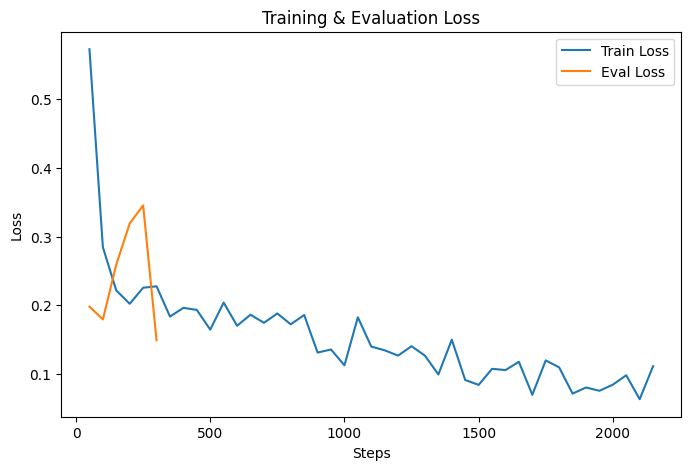

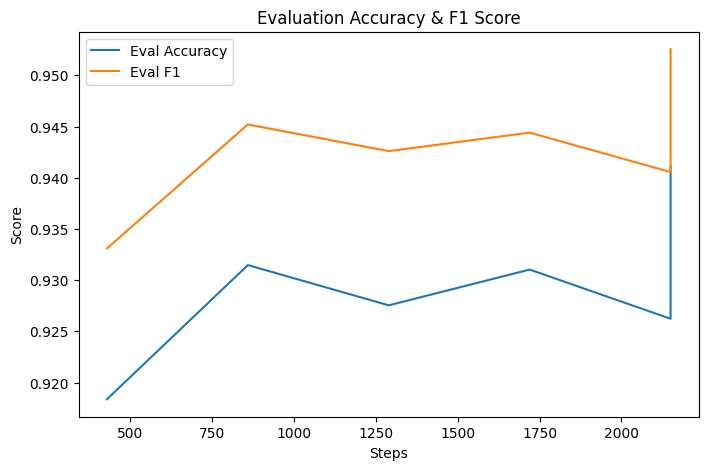

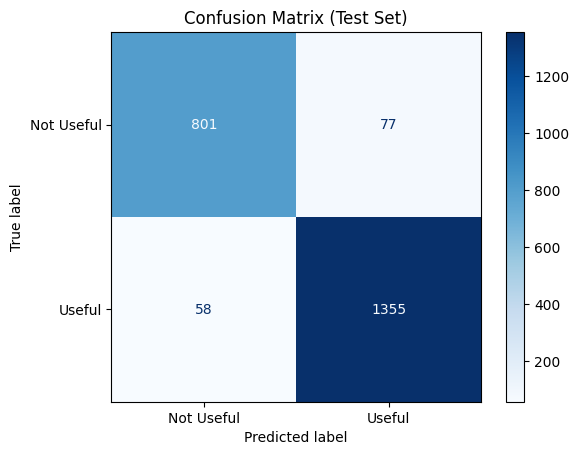

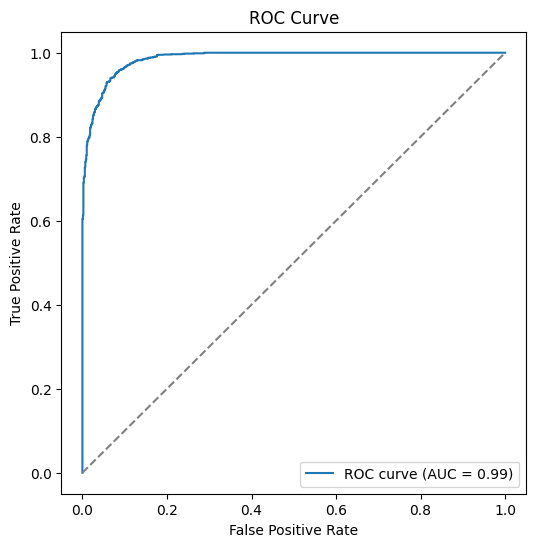

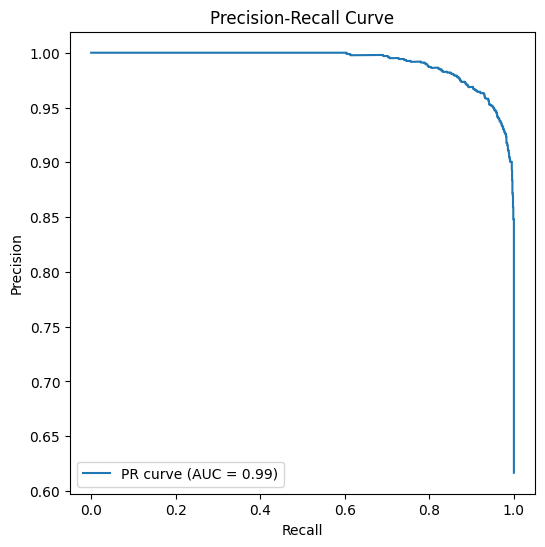

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve

# ===============================
# 1. Plot Training Loss Curve
# ===============================
log_history = trainer.state.log_history
train_loss = [x["loss"] for x in log_history if "loss" in x]
eval_loss = [x["eval_loss"] for x in log_history if "eval_loss" in x]
steps = [x["step"] for x in log_history if "loss" in x]

plt.figure(figsize=(8,5))
plt.plot(steps, train_loss, label="Train Loss")
plt.plot(steps[:len(eval_loss)], eval_loss, label="Eval Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training & Evaluation Loss")
plt.legend()
plt.show()

# ===============================
# 2. Accuracy & F1 over Steps
# ===============================
eval_acc = [x["eval_accuracy"] for x in log_history if "eval_accuracy" in x]
eval_f1 = [x["eval_f1"] for x in log_history if "eval_f1" in x]
eval_steps = [x["step"] for x in log_history if "eval_accuracy" in x]

plt.figure(figsize=(8,5))
plt.plot(eval_steps, eval_acc, label="Eval Accuracy")
plt.plot(eval_steps, eval_f1, label="Eval F1")
plt.xlabel("Steps")
plt.ylabel("Score")
plt.title("Evaluation Accuracy & F1 Score")
plt.legend()
plt.show()

# ===============================
# 3. Confusion Matrix
# ===============================
preds = trainer.predict(test_tokenized)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Useful", "Useful"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Test Set)")
plt.show()

# ===============================
# 4. ROC Curve
# ===============================
y_scores = preds.predictions[:,1]  # probability of class "Useful"
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1],"--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# ===============================
# 5. Precision–Recall Curve
# ===============================
prec, rec, thresholds = precision_recall_curve(y_true, y_scores)

# Compute AUC for PR curve
pr_auc = auc(rec, prec)

plt.figure(figsize=(6,6))
plt.plot(rec, prec, label=f"PR curve (AUC = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()
